In [21]:
%matplotlib inline
%run prelims
import opc_python
import numpy as np
import matplotlib.pyplot as plt
import pandas
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
descriptors = loading.get_descriptors()
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
#mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
#mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)

Morgan has 2437 features for 476 molecules.
There are now 7307 total features.


### Create matrices

In [3]:
# Create the feature matrices from the feature dicts.  
# Create the feature matrices from the feature dicts.  
X_train,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,['training-norep','leaderboard'])
X_test_other,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,"replicated",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_test_int,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,"replicated",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (774x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x5497) molecules by non-NaN good molecular descriptors


In [4]:
from sklearn.preprocessing import MinMaxScaler
def quad_prep(mdx,sets,dilution=None):
    X_temp,_,_,_,_,_ = dream.make_X(mdx,sets,target_dilution=dilution,raw=True)
    X_temp[np.isnan(X_temp)] = 0
    X_scaled = MinMaxScaler().fit_transform(X_temp[:,:-2])
    X_scaled_sq = np.hstack((X_scaled,X_scaled**2,X_temp[:,-2:]))
    return X_scaled_sq
X_train_lin = quad_prep(mdx_drag_morg,sets=['training-norep','leaderboard'])
X_test_lin_other = quad_prep(mdx_drag_morg,sets='replicated',dilution='high')
X_test_lin_int = quad_prep(mdx_drag_morg,sets='replicated',dilution=-3)

The X matrix now has shape (774x7308) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x7308) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x7308) molecules by non-NaN good molecular descriptors


In [5]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_train_imp,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='median')
Y_train_mask,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject


In [6]:
# Create descriptor matrices for the leaderboard set.  
# One is done with median imputation, and the other with no imputation 
Y_test_other,imputer = dream.make_Y_obs('replicated',target_dilution='high',imputer='mask')
Y_test_int,imputer = dream.make_Y_obs('replicated',target_dilution=-3,imputer='mask') # WAS imputer=None, i.e. median

The Y['mean_std'] matrix now has shape (20x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (20x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (15x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (15x21) molecules by perceptual descriptors, one for each subject


In [7]:
trans_params = params.get_trans_params(Y_train_mask, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

In [8]:
codes = ['Intensity',
'Valence/pleasantness',
'Bakery',
'swEet',
'fRuit',
'Fish',
'garLic',
'sPices',
'Cold',
'Sour',
'burNt',
'Acid',
'Warm',
'musKy',
'sweaTy',
'ammonia/Urinous',
'decaYed',
'wooD',
'Grass',
'flOwer',
'cheMical']
letters = [[x for x in code if (x.upper() == x and x!='/') ][0] for code in codes]
print(len(set(letters)))

21


In [9]:
data = loading.load_data_matrix(gold_standard_only=True, only_replicates=True)
rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

In [10]:
CIDs_with_1000fold = [int(x.split('_')[0]) for x in loading.get_CID_dilutions('replicated') if '-3' in x]
CIDs = loading.get_CIDs('replicated')
intensity_mask = [i for i,x in enumerate(CIDs) if x in CIDs_with_1000fold]

In [938]:
n_estimators = 200
#rfcs_norep_2,score_2,rs_2 = fit2.rfc_final(X_train,Y_train_imp['mean_std'],
#                                           Y_train_mask['mean_std'],max_features,
#                                           min_samples_leaf,max_depth,use_et,use_mask,
#                                           trans_weight,trans_params,
#                                           n_estimators=n_estimators)
import pickle
#with open('../../data/rfcs_norep_2.pickle','wb') as f:
#    pickle.dump(rfcs_norep_2,f)
with open('../../data/rfcs_norep_2.pickle','rb') as f:
    rfcs_norep_2 = pickle.load(f)

In [753]:
# Make challenge 2 leaderboard prediction files from the models.  
# There are 20 replications for the high concentration, but only 15 for the 1/1000
# concentration, so these have to be computed separately.  
Y_pred_2 = loading.make_prediction_files(rfcs_norep_2,X_test_int,X_test_other,
                              'replicated',2,intensity_mask=intensity_mask,Y_test=None,
                              write=False,trans_weight=trans_weight,trans_params=trans_params)

y_pred_2 = np.ma.array(Y_pred_2['mean_std'],mask=False)
y_pred_2.mask[:,0:42:21] = True
y_pred_2.mask[intensity_mask,0:42:21] = False

y_obs_2 = np.ma.array(Y_test_other['mean_std'],mask=False)
y_obs_2[:,0:42:21] = True
y_obs_2.mask[intensity_mask,0:42:21] = Y_test_int['mean_std'][:,0:42:21]

scoring.score_summary2(y_pred_2,y_obs_2,mask=True)

'Score: 7.654339; rs = 0.000,0.727,0.539,0.000,0.366,0.468'

In [911]:
# Subchallenge 2: Mean Coefficients of Error.
sc2_cv = np.empty(21)
trt2_cv = np.empty(21)

for d in range(21):
    dil = 1 if d==0 else slice(None)
    o = data[:,:,d,dil,0][:,rep_indices,...].mean(axis=0) # For some reason putting rep_indices in the first brackets
                                                          # changes the order of the array dimensions.  
    r = data[:,:,d,dil,1][:,rep_indices,...].mean(axis=0)
    if len(o.shape)==2:
        o = o.mean(axis=1) # Collapse the dilution dimension
    if len(r.shape)==2:
        r = r.mean(axis=1) # Collapse the dilution dimension
    p = y_pred_2[:,d]
    
    # Model vs First Test
    x = (o - p).compressed()
    sc2_cv[d] = np.ma.corrcoef(o,p)[1,0]#np.sqrt((x**2).mean() - x.mean()**2) / o.mean()
    
    # First Test vs Second Test
    x = (o - r).compressed()
    trt2_cv[d] = np.ma.corrcoef(o,r)[1,0]#np.sqrt(((x**2).mean() - x.mean()**2)/2) / o.mean()

In [915]:
# Subchallenge 2: Jacknife samples of the Coefficients of Error.
sc2_cv_jn = np.ma.array(np.empty((21,20)),mask=True)
trt2_cv_jn = np.ma.array(np.empty((21,20)),mask=True)

for d in range(21):
    # Model vs Test (data)
    dil = 1 if d==0 else slice(None)
    for i in range(20):
        indices = [j for j in range(20) if j!=i]
        o = data[:,:,d,dil,0][:,rep_indices,...].mean(axis=0)
        r = data[:,:,d,dil,1][:,rep_indices,...].mean(axis=0)
        if len(o.shape)==2:
            o = o.mean(axis=1) # Collapse the dilution dimension
        if len(r.shape)==2:
            r = r.mean(axis=1) # Collapse the dilution dimension
        p = y_pred_2[:,d]
        
        if not o.mask[i]:
            # Model vs First Test
            x = (o - p)[indices].compressed()
            sc2_cv_jn[d,i] = np.ma.corrcoef(o[indices],p[indices])[1,0]#np.sqrt((x**2).mean() - x.mean()**2) / o.mean()

            # First Test vs Second Test
            x = (o - r)[indices].compressed()
            trt2_cv_jn[d,i] = np.ma.corrcoef(o[indices],r[indices])[1,0]#np.sqrt(((x**2).mean() - x.mean()**2)/2) / o.mean()

In [11]:
def plot_coe(sc_mean,trt_mean,subchallenge,sc_err=None,trt_err=None,scale='auto'):
    plt.figure(figsize=(12,12))
    if scale == 'auto':
        limit = max(sc_mean.max(),trt_mean.max())*1.1
    else:
        limit = scale
    x = np.linspace(0,limit,100)
    plt.plot(x,x,'--',c='r',linewidth=4)
    plt.errorbar(sc_mean,trt_mean,xerr=sc_err,yerr=trt_err,c='white',ecolor='black',fmt='o',markersize=15)  
    plt.xlabel('Model-Test Coef. of Variation',size=30)
    plt.ylabel('Test-Retest Coef. of Variation',size=30)
    plt.xlim(0,limit)
    plt.ylim(0,limit)
    ticks = np.arange(1+int(limit))
    plt.xticks(ticks,ticks,size=22)
    plt.yticks(ticks,ticks,size=22)
    from scipy.stats import linregress, ttest_rel
    _,p = ttest_rel(sc_mean,trt_mean)
    r = np.corrcoef(sc_mean,trt_mean)[0,1]
    z = np.zeros(10000)
    coefs = linregress(np.concatenate((z,sc_mean)),np.concatenate((z,trt_mean))) # Zeros force the intercept to be zero
    plt.plot(x,x*coefs.slope + coefs.intercept,'-',c='k')
    plt.legend(loc=2)
    plt.text(limit*0.7,limit*0.1,'r = %.3f\nslope = %.3f' % (r,coefs.slope),size=22)
    plt.title("Model Performance vs Retest Reliability",size=30)# % subchallenge)
    for i in range(21):
        plt.text(sc_mean[i]*1.0,trt_mean[i],letters[i],fontdict={'color':'blue','size':12,'weight':'bold'},
                 horizontalalignment='center',verticalalignment='center')

In [58]:
def plot_r(sc_mean,trt_mean,subchallenge,sc_err=None,trt_err=None,scale='auto'):
    plt.figure(figsize=(12,12))
    x = np.linspace(-1,1,100)
    plt.plot(x,x,'--',c='r',linewidth=4)
    plt.errorbar(trt_mean,sc_mean,xerr=trt_err,yerr=sc_err,c='white',ecolor='black',fmt='o',markersize=15)  
    plt.xlabel('Test-Retest Correlation',size=30)
    plt.ylabel('Model-Test Correlation',size=30)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    #ticks = np.arange(1+int(limit))
    #plt.xticks(ticks,ticks,size=22)
    #plt.yticks(ticks,ticks,size=22)
    from scipy.stats import linregress, ttest_rel
    _,p = ttest_rel(sc_mean,trt_mean)
    r = np.corrcoef(sc_mean,trt_mean)[0,1]
    z = np.zeros(0)#10000)
    coefs = linregress(np.concatenate((z,trt_mean)),np.concatenate((z,sc_mean))) # Zeros force the intercept to be zero
    plt.plot(x,x*coefs.slope + coefs.intercept,'-',c='k')
    plt.legend(loc=2)
    plt.text(0.4,0.01,'r = %.3f\nslope = %.2f+/-%.2f' % (r,coefs.slope,coefs.stderr),size=22)
    #plt.title("Model Performance vs Retest Reliability",size=30)# % subchallenge)
    for i in range(21):
        plt.text(trt_mean[i],sc_mean[i],letters[i],fontdict={'color':'blue','size':12,'weight':'bold'},
                 horizontalalignment='center',verticalalignment='center')

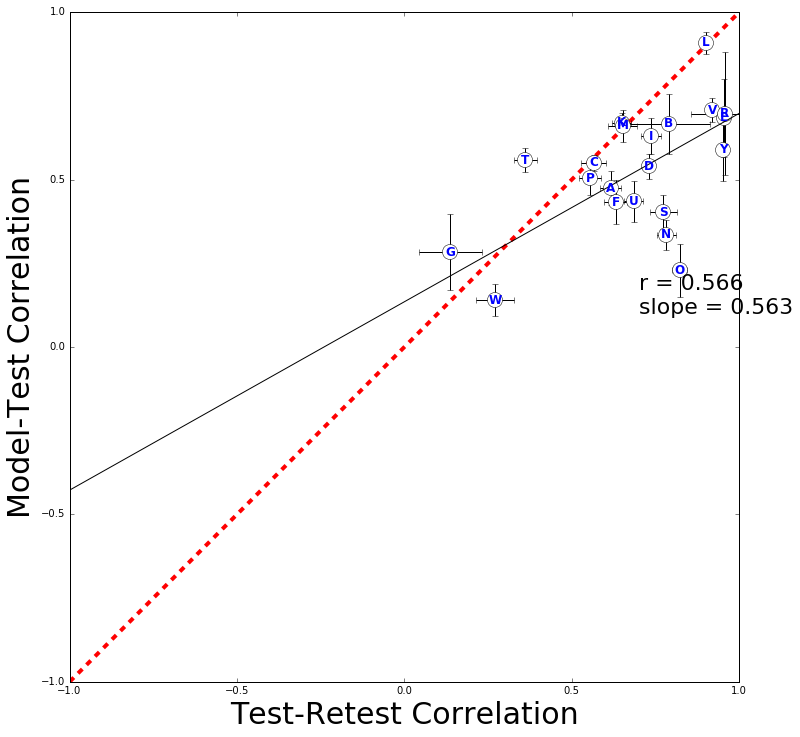

In [921]:
# Subchallenge 2: Coefficients of error for test/retest vs model/test
plot_r(sc2_cv,trt2_cv,2,sc_err=sc2_cv_jn.std(axis=1),trt_err=trt2_cv_jn.std(axis=1))

In [917]:
# Fraction of the density around each point that is above (vs below) the unity line.  
from scipy.stats import multivariate_normal,chi2
n_rvs = 100000
ps = np.zeros(21)
for d in range(21):
    rvs = multivariate_normal.rvs([sc2_cv_jn.mean(axis=1)[d],trt2_cv_jn.mean(axis=1)[d]],
                                  [[sc2_cv_jn.std(axis=1)[d]**2,0],
                                   [0,trt2_cv_jn.std(axis=1)[d]**2]],
                                  n_rvs)
    ps[d] = ((rvs[:,1] - rvs[:,0]) < 0).sum()/n_rvs
ps_fdr = np.zeros(21)
for d in range(21):
    ps_fdr[d] = ps[d] * 21 / (1+list(np.argsort(ps)).index(d))
    if ps_fdr[d] < 0.001: 
        stars = '***'
    elif ps_fdr[d] < 0.01: 
        stars = '**'
    elif ps_fdr[d] < 0.05: 
        stars = '*'
    else:
        stars = ''
    print("%s: %.4f %s" % (descriptors[d],ps_fdr[d],stars))
    #print("%s: %.4f (%.4f) %s" % (descriptors[d],ps[d],ps_fdr[d],stars))

fisher = -np.log(ps).sum()*2
print("Pooled p = %.19g" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[1:]).sum()*2
print("Pooled p = %.3g (ignoring intensity)" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[2:]).sum()*2
print("Pooled p = %.3g (ignoring intensity and pleasantness)" % (1-chi2.cdf(fisher,42)))

INTENSITY/STRENGTH: 0.0703 
VALENCE/PLEASANTNESS: 0.0000 ***
BAKERY: 0.3376 
SWEET: 0.0172 *
FRUIT: 0.1606 
FISH: 0.0102 *
GARLIC: 0.6349 
SPICES: 0.3135 
COLD: 0.4660 
SOUR: 0.0000 ***
BURNT: 0.0000 ***
ACID: 0.0159 *
WARM: 0.0751 
MUSKY: 0.7747 
SWEATY: 1.0000 
AMMONIA/URINOUS: 0.0002 ***
DECAYED: 0.0000 ***
WOOD: 0.0000 ***
GRASS: 0.8599 
FLOWER: 0.0000 ***
CHEMICAL: 0.6279 
Pooled p = 0
Pooled p = 0 (ignoring intensity)
Pooled p = 0 (ignoring intensity and pleasantness)


## Subchallenge 1

### Random Forest

In [14]:
import pickle 
n_estimators = 25
#rfcs_norep_1,score_1,rs_1 = fit1.rfc_final(X_train,Y_train_imp['subject'],
#                                     max_features,min_samples_leaf,max_depth,use_et,regularize,
#                                     n_estimators=n_estimators)
#with open('../../data/rfcs_norep_1.pickle','wb') as f:
#    pickle.dump(rfcs_norep_1,f)
with open('../../data/rfcs_norep_1.pickle','rb') as f:
    rfcs_norep_1 = pickle.load(f)

In [15]:
Y_pred_1 = loading.make_prediction_files(rfcs_norep_1,X_test_int,X_test_other,
                                     'replicated',1,intensity_mask=intensity_mask,Y_test=None,
                                      write=False,regularize=regularize)#[0.8]*21)

In [16]:
# Make challenge 1 leaderboard prediction files from the models.  
# There are 20 replications for the high concentration, but only 15 for the 1/1000
# concentration, so these have to be computed separately.  

y_pred_1 = np.ma.dstack([Y_pred_1['subject'][i] for i in range(1,50)])

y_obs_1 = np.ma.dstack([Y_test_other['subject'][i] for i in range(1,50)])
y_obs_1.mask[:,0,:] = True
for i in range(49):
    y_obs_1[intensity_mask,0,i] = Y_test_int['subject'][i+1][:,0]

scoring.score_summary(y_pred_1,y_obs_1,mask=True)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


'Score: 29.384339; rs = 0.389,0.408,0.186'

### Linear (Quadratic)

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import RandomizedLasso
lin_ranked_rick = np.zeros((21,14613)).astype(int) # Matrix to store the score rankings.  
rl = RandomizedLasso(alpha=0.025,selection_threshold=0.025,n_resampling=10,random_state=25,n_jobs=1)
for col in range(21):
    print(col)
    observed = Y_train_mask['mean_std'][:,col]
    X = X_train_lin[:,:-1] # Remove leak feature
    rl.fit(X,observed)
    lin_ranked_rick[col,:] = np.argsort(rl.all_scores_.ravel())[::-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [18]:
from sklearn.linear_model import Ridge
max_features = 100
y_pred_lin = np.ma.array(np.zeros((20,21,49)),mask=True)
for col in range(21): # For each descriptor.  
    X_test = X_test_lin_int if col==0 else X_test_lin_other
    n_mol = X_test.shape[0]
    for subject in range(1,50):
        observed = Y_train_imp['subject'][subject][:,col] # Perceptual data for this descriptor.  
        est = Ridge(alpha=10.0,fit_intercept=True, normalize=False, 
                        copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=0)
        importance_ranks = lin_ranked_rick[col,:] # Use the pre-computed ranks for the first cv split (to fix).
        est.fit(X_train_lin[:,:-1][:,importance_ranks[:max_features]],
                observed) # Fit the model on the training data with max_features features.
        predicted = est.predict(X_test[:,importance_ranks[:max_features]]) # Predict the test data.  
        y_pred_lin[:n_mol,col,subject-1] = predicted
    y_pred_lin = y_pred_lin.mean(axis=2)[...,np.newaxis]*0.8 + y_pred_lin*0.2

In [40]:
y_pred = (y_pred_1 + y_pred_lin)/2

In [41]:
# Subchallenge 1

# Load the data into a n_subjects x n_molecules x n_descriptors x n_dilutions x n_replications matrix.  
# This is masked so only gold standard (1/1000 for intensity, high for every other descriptor) is visible, 
# and only for the 20 replicated molecules.  Every other entry is masked and will not affect any calculation.  
#data = loading.load_data_matrix(gold_standard_only=True, only_replicates=True) 

# Extract the indices of the 20 replicated molecules.  
rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

# Subchallenge 1: Jacknife samples of the Coefficients of Error.
sc1_cv = np.empty(21) # Empty array of length 21.  Will hold Model vs. Test
trt1_cv = np.empty(21) # Empty array of length 21.  Will hold Test vs Retest

for d in range(21): # Iterate over each descriptor.  
    mses_sc1 = np.ma.masked_all(49) # Empty masked array to hold model vs test correlations for each the 49 subjects.  
    mses_trt = np.ma.masked_all(49) # Empty masked array to hold test vs retest correlations for each the 49 subjects.  
    for s in range(49): # Iterate over subjects.  
        o = data[s,rep_indices,d,:,0] # Select test (first trial values) for the replicated molecules.  
        r = data[s,rep_indices,d,:,1] # Select retest (first trial values) for the replicated molecules.  
        o = o.mean(axis=1) # Collapse the dilution dimension.  All non-gold standard dilutions are masked anyway.  
        r = r.mean(axis=1) # Collapse the dilution dimension. All non-gold standard dilutions are masked anyway.  
        p = y_pred[:,d,s] # Select the predicted values for the same molecules. (y_pred_1 has those 20 molecules)  
        
        # To avoid biasing towards test or retest, compute the length-40 vector of concatenated test and retest
        # values for this subject/descriptor.  Compute correlated of corresponding length-40 vector which just has
        # the 20 predicted values listed twice.  
        mses_sc1[s] = np.ma.corrcoef(np.ma.concatenate((o,r)),np.ma.concatenate((p,p)))[0,1]
        
        # Now compute correlation between test and retest.  
        mses_trt[s] = np.ma.corrcoef(o,r)[0,1]
    # Compute the mean across subjects of these within-subject correlations.  
    sc1_cv[d] = mses_sc1.mean()
    trt1_cv[d] = mses_trt.mean()

In [42]:
# Subchallenge 1: Jacknife samples of the Coefficients of Error.
sc1_cv_jn = np.ma.empty((21,20)) # Empty masked array of length 21.  Model vs. Test
trt1_cv_jn = np.ma.empty((21,20)) # Empty masked array of length 21.  Test vs Retest

for d in range(21):
    dil = slice(None)#1 if d==0 else slice(None)
    for i in range(20):
        indices = [j for j in range(20) if j!=i]
        mses_sc1 = np.ma.masked_all(49)
        mses_trt = np.ma.masked_all(49)
        for s in range(49):
            o = data[s,rep_indices,d,dil,0]
            r = data[s,rep_indices,d,dil,1]
            if len(o.shape)==2:
                o = o.mean(axis=1) # Collapse the dilution dimension
            if len(r.shape)==2:
                r = r.mean(axis=1) # Collapse the dilution dimension
            p = y_pred[:,d,s]
            #p = np.ones_like(p)*y_pred_1[:,d,s].mean() + np.random.rand(20) # Random model
            
            if not o.mask[i]:
                #x = np.concatenate(((o - p).compressed(),(r - p).compressed()))
                #x = (o - p)[indices].compressed()
                #mses_sc1[s] = (x**2).mean() - x.mean()**2
                mses_sc1[s] = np.ma.corrcoef(np.ma.concatenate((o[indices],r[indices])),np.ma.concatenate((p[indices],p[indices])))[0,1]
                
                #x = (o - r)[indices].compressed()
                #mses_trt[s] = ((x**2).mean() - x.mean()**2)/2
                mses_trt[s] = np.ma.corrcoef(o[indices],r[indices])[0,1]

        o_jn_all = data[:,:,d,dil,:].mean()#np.delete(data[:,:,d,dil,0],i,axis=0).mean()
        #sc1_cv_jn[d,i] = np.sqrt(mses_sc1.mean()) / o_jn_all
        #trt1_cv_jn[d,i] = np.sqrt(mses_trt.mean()) / o_jn_all
        sc1_cv_jn[d,i] = mses_sc1.mean()
        trt1_cv_jn[d,i] = mses_trt.mean()
        #sc1_cv_jn[d,i] = np.tanh(np.arctanh(mses_sc1).mean())
        #trt1_cv_jn[d,i] = np.tanh(np.arctanh(mses_trt).mean())

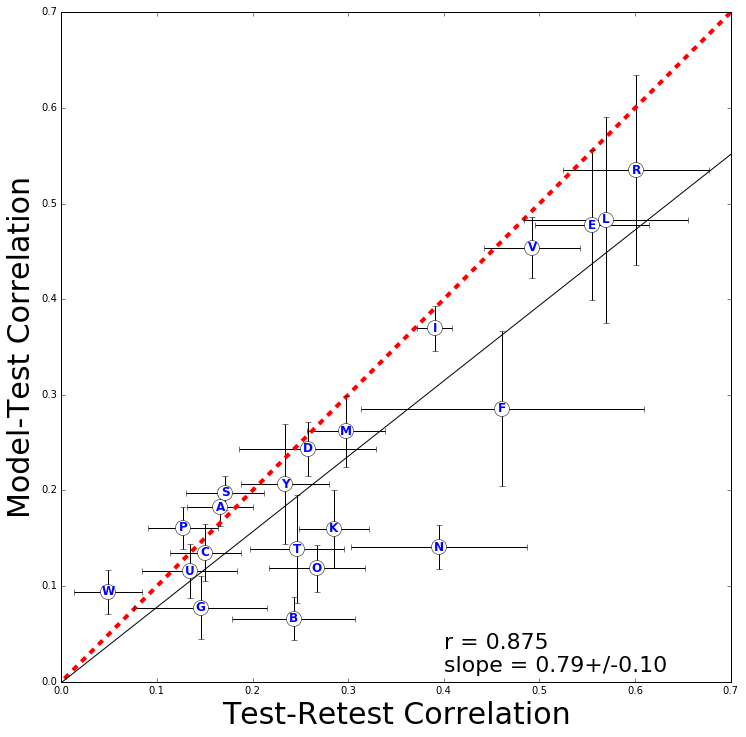

In [59]:
# Subchallenge 1: Coefficients of error for test/retest vs model/test
plot_r(sc1_cv_jn.mean(axis=1),trt1_cv_jn.mean(axis=1),1,sc_err=sc1_cv_jn.std(axis=1),trt_err=trt1_cv_jn.std(axis=1))
plt.savefig('../../figures/test-retest.eps',format='eps')

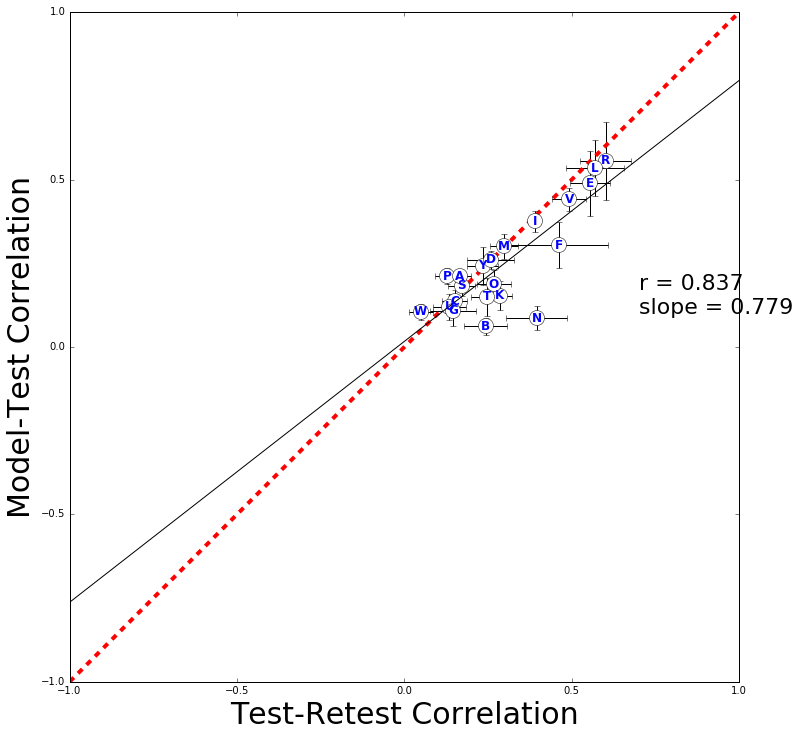

In [36]:
# Subchallenge 1: Coefficients of error for test/retest vs model/test
plot_r(sc1_cv_jn.mean(axis=1),trt1_cv_jn.mean(axis=1),1,sc_err=sc1_cv_jn.std(axis=1),trt_err=trt1_cv_jn.std(axis=1))

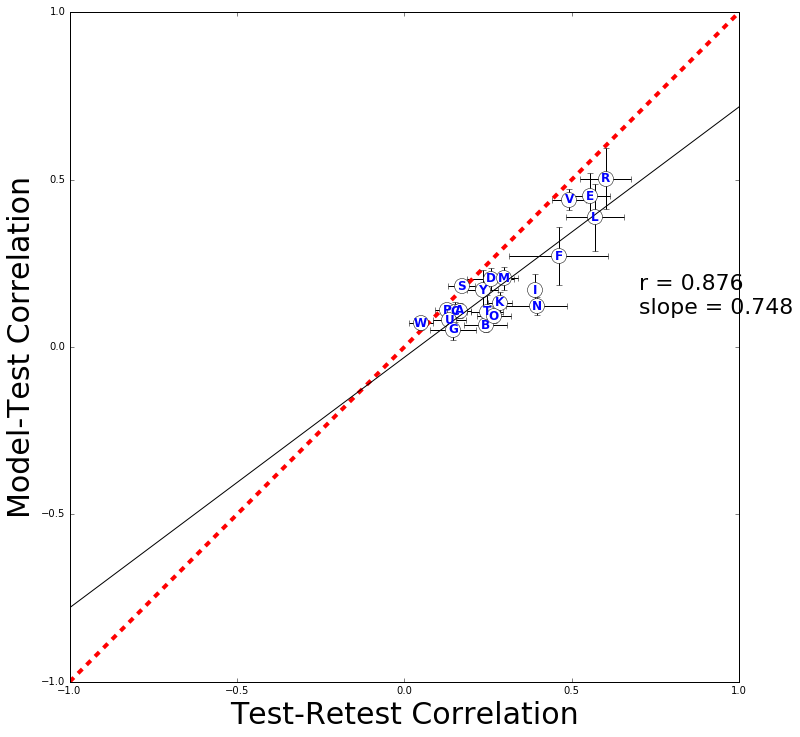

In [32]:
# Subchallenge 1: Coefficients of error for test/retest vs model/test
plot_r(sc1_cv_jn.mean(axis=1),trt1_cv_jn.mean(axis=1),1,sc_err=sc1_cv_jn.std(axis=1),trt_err=trt1_cv_jn.std(axis=1))

In [48]:
# Fraction of the density around each point that is above (vs below) the unity line.  
from scipy.stats import multivariate_normal,chi2
n_rvs = 1000000
ps = np.zeros(21)
for d in range(21):
    rvs = multivariate_normal.rvs([sc1_cv_jn.mean(axis=1)[d],trt1_cv_jn.mean(axis=1)[d]],
                                  [[sc1_cv_jn.std(axis=1)[d]**2,0],
                                   [0,trt1_cv_jn.std(axis=1)[d]**2]],
                                  n_rvs)
    ps[d] = ((rvs[:,1] - rvs[:,0]) < 0).sum()/n_rvs
ps_fdr = np.zeros(21)
for d in range(21):
    ps_fdr[d] = ps[d] * 21 / (1+list(np.argsort(ps)).index(d))
    if ps_fdr[d] < 0.001: 
        stars = '***'
    elif ps_fdr[d] < 0.01: 
        stars = '**'
    elif ps_fdr[d] < 0.05: 
        stars = '*'
    else:
        stars = ''
    print("%s: %.4f %s" % (descriptors[d],ps_fdr[d],stars))
    #print("%s: %.4f (%.4f) %s" % (descriptors[d],ps[d],ps_fdr[d],stars))

fisher = -np.log(ps).sum()*2
print("Pooled p = %.3g" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[1:]).sum()*2
print("Pooled p = %.3g (ignoring intensity)" % (1-chi2.cdf(fisher,42)))

fisher = -np.log(ps[2:]).sum()*2
print("Pooled p = %.3g (ignoring intensity and pleasantness)" % (1-chi2.cdf(fisher,42)))

INTENSITY/STRENGTH: 0.5710 
VALENCE/PLEASANTNESS: 0.5407 
BAKERY: 0.0325 *
SWEET: 0.5642 
FRUIT: 0.4821 
FISH: 0.5205 
GARLIC: 0.4625 
SPICES: 0.8230 
COLD: 0.4881 
SOUR: 0.7986 
BURNT: 0.0767 
ACID: 0.7689 
WARM: 0.8579 
MUSKY: 0.0602 
SWEATY: 0.3147 
AMMONIA/URINOUS: 0.5177 
DECAYED: 0.5432 
WOOD: 0.5277 
GRASS: 0.5625 
FLOWER: 0.0397 *
CHEMICAL: 0.4927 
Pooled p = 0.000301
Pooled p = 0.000623 (ignoring intensity)
Pooled p = 0.00123 (ignoring intensity and pleasantness)


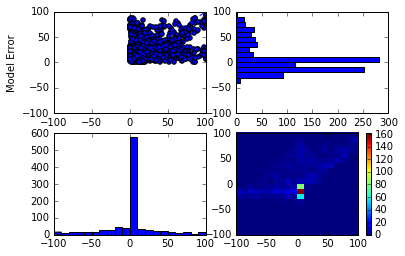

In [752]:
d = 20
dil = 1 if d==0 else slice(None)
p = y_pred_1[:,d,:].T
#p = np.ones(p.shape)*p.mean()
o = data[:,:,d,dil,0][:,rep_indices]
r = data[:,:,d,dil,1][:,rep_indices]
if d>0:
    o = o.mean(axis=2)
    r = r.mean(axis=2)
fig,ax = plt.subplots(2,2)
ax[0,0].scatter(np.abs((o-r).ravel().compressed()).ravel(),np.abs((o-p).compressed()).ravel())
ax[0,0].scatter(np.abs((o-r).compressed()).ravel(),np.abs((r-p).compressed()).ravel())
ax[0,0].plot([0,100],[0,100],'--')
ax[0,0].set_xlabel('Test Error')
ax[0,0].set_ylabel('Model Error')
ax[0,0].set_xlim(-100,100)
ax[0,0].set_ylim(-100,100)
ax[1,0].hist((o-r).ravel(),bins=np.linspace(-100,100,21))
ax[1,0].set_xlim(-100,100)
ax[0,1].hist((o-p).ravel(),bins=np.linspace(-100,100,21),orientation='horizontal');
ax[0,1].set_ylim(-100,100)
_,_,_,z = ax[1,1].hist2d((o-r).compressed().ravel(),(o-p).compressed().ravel(),
                   bins=np.linspace(-100,100,21))
ax[1,1].set_xlim(-100,100)
ax[1,1].set_ylim(-100,100)
fig.colorbar(z);